In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [8]:
%matplotlib inline

In [15]:
# Read in data
X_train = pd.read_csv("../data/scaled_X_train.csv")
y_train = pd.read_csv("../data/scaled_y_train.csv")
X_test = pd.read_csv("../data/scaled_X_test.csv")
y_test = pd.read_csv("../data/scaled_y_test.csv")

X_train.head()

,year,democrat_perc,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,-1.0,1.187014,1.023277,0.984646,0.850506,0.178410,1.221901,-0.004104,-0.036893,0.021631,0.023977,-0.025684
1,-1.0,1.199637,0.023937,-0.383640,-0.462143,-0.750147,-0.009682,0.026937,0.080594,0.070108,-0.025834,-0.083322
2,-1.0,-0.572699,-1.057257,-1.294860,-1.396147,-0.280227,-1.590602,-0.473441,-0.440902,-0.402933,-0.376713,-0.337893
3,-1.0,0.833619,0.072848,0.041553,-0.012319,0.112448,0.760825,-0.216729,-0.353839,-0.324579,-0.287681,-0.215065
4,-1.0,0.756480,-0.606384,-0.832131,-0.890741,-0.309058,0.428678,-0.623486,-0.444504,-0.301532,-0.277814,-0.221680


In [46]:
# Initialize lasso model
a_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1] # lists of alpha value

lasso = LassoCV(n_alphas=len(a_list), alphas=a_list, cv=10, max_iter=100000,random_state=26).fit(X_train, y_train.values.ravel())

# Store the mean cross-validation MSEs across each fold
lassoCV_val_mses_mean = lasso.mse_path_
# Save the best 𝛼 based on the mean cross-validation MSE
best_alpha = lasso.alpha_
best_alpha

1e-05

In [47]:
# Modal diagnostics
train_score = lasso.score(X_train,y_train)
test_score = lasso.score(X_test,y_test)

print("The train score for the lasso model is " + str(train_score))
print("The test score for the lasso model is " + str(test_score))

The train score for the lasso model is 0.9035218607760591
The test score for the lasso model is 0.4793922444360281


Text(0.5, 1.0, 'Coefficient value')

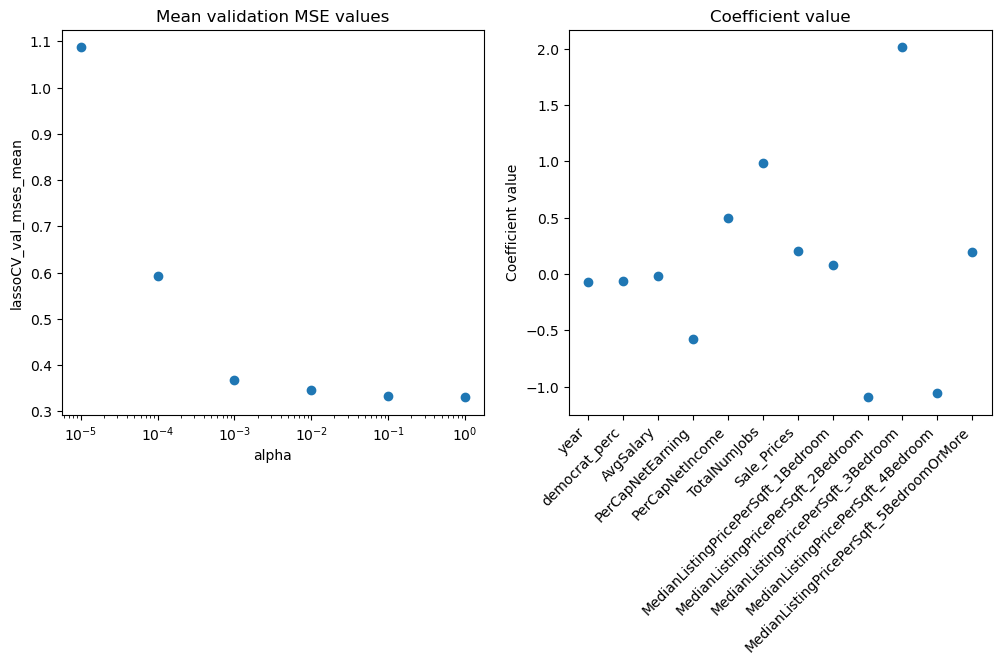

In [65]:
fig,axs = plt.subplots(1,2,figsize=(12, 5))

axs[0].scatter(a_list,np.mean(lassoCV_val_mses_mean,axis=1).tolist())
axs[0].set_xscale('log')
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('lassoCV_val_mses_mean')
axs[0].set_title("Mean validation MSE values")

axs[1].scatter(np.linspace(1,lasso.coef_.shape[0],lasso.coef_.shape[0]),lasso.coef_)
axs[1].set_xticks(np.arange(1,13))
axs[1].set_xticklabels(X_train.columns, rotation=45, ha='right')
axs[1].set_ylabel('Coefficient value')
axs[1].set_title("Coefficient value")

In [66]:
# Select non-zero coefficients
lasso.get_support()

AttributeError: 'LassoCV' object has no attribute 'get_support'